<a href="https://colab.research.google.com/github/qhowery/COS324_PA3/blob/main/COS324_PA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment 3: Low Rank Matrix Approximation

<p>
    

<font size="3">

In this assignment, we will use low-rank approximation of matrices, which is useful for finding hidden relationships that might not be apparent from high-dimensional data.

**SUBMISSION NOTE:** Because we defined a few custom LaTeX definitions, `nbconvert` may not work to render those custom equations. Instead, use "File > Print" and select the "Save as PDF" option. If that doesn't work for you, you may still be able to use `nbconvert` as long as your code and answers to conceptual questions are readable (we don't need to be able to read the LaTeX code we give you).
</font>

$$
\def\M{\mathsf{M}}
\def\A{\mathsf{A}}
\def\B{\mathsf{B}}
\def\Mhat{\hat{\mathsf{M}}}
\def\O{\mathcal{O}}
\def\OO{\mathsf{O}}
\def\a{\mathbf{a}}
\def\b{\mathbf{b}}
\def\1{\mathbf{1}}
\def\reals{\mathbb{R}}
$$

<hr style="border:3px solid blue"> </hr>

## **Part 1: Implementing Low-Rank Matrix Approximation (LORMA)**

## Formal definition and notation

In this assignment you will be required to approximate a partially observed (typically) large matrix using a product of low rank matrices. Let us recap the ingredients of low rank matrix approximation:  <p>

- Observed matrix $\mathsf{M}$ of size $m \times n$ with real valued entries and missing values <p>
    
- Low rank matrices $\mathsf{A}$ of size $m \times k$ and $\mathsf{B}$ of size $k \times n$ <p>
    
- We would like to find $\mathsf{A}, \mathsf{B}$ such that $\mathsf{M} \approx \mathsf{A} \mathsf{B}$. We will denote $\hat{\mathsf{M}} = \mathsf{A}\mathsf{B}$ <p>
    
We are going to measure the goodness of approximation using the squared error at entries $(i,j)$ for which we know the value of $\mathsf{M}_{ij}$ (entries where the matrix is observed, denoted as $\mathsf{O} = \{(i,j) \mbox{ s.t. } \mathsf{M}_{ij} \mbox{ observed}\}$). Therefore the loss is,
$$
 \mathcal{L} = \frac{1}{|\mathcal{O}|} \sum_{(i,j)\in \mathcal{O}} \! \big(\mathsf{M}_{ij} -  \hat{\mathsf{M}}_{ij}\big)^2 ~.
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ACT1: Implement average squared loss function.
# Given M, M_approx, O return the average squared loss over the observed entries.
# M is an m x n 2-D numpy array containing the observed entries (with
#   arbitrary values in the unobserved entries)
# M_approx is an m x n 2-D numpy array representing the low-dimensional approximation
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
#   1 if the entry is observed in M. O tells you which entries in M were observed
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def loss(M, M_approx, O):
    ### ACT1: add your code here
    sum = np.square(np.subtract(M, M_approx))
    sum = np.sum(sum[O == 1])
    length = np.size(O)
    return (1 / length) * sum

<hr style="border:3px solid blue"> </hr>


## Normalization of M

As the initial prediction of $\hat{\mathsf{M}}$ would likely to have entries following a standard normal distribution and  we use the squared error as the sole loss, it would be a good practice for us to do normalization for $\mathsf{M}$ prior to the learning process. This means that we will preprocess matrix $\mathsf{M}$ so that the average over its observed entries would be $0$ and the empirical distribution of its entries would resemble a standard normal distribution.   

Mathematically speaking, let us normalize $\mathsf{M}$ such that,
$$\sum_{(i,j)\in \mathcal{O}} \mathsf{M}_{ij} = 0 ~ \mbox{ and } ~ \frac{1}{|\mathcal{O}|} \sum_{(i,j)\in \mathcal{O}} \mathsf{M}^2_{ij} = 1 ~ .$$
This can be achieved by finding two scalar $a$ and $s$ such that after the transformation,
$\mathsf{M} \mapsto (\mathsf{M} - a) / s$ the matrix is normalized.

Specifically, $a$ and $s$ are the mean and standard deviation of the observed entries in $\mathsf{M}$:
$$a = \frac{1}{|\mathcal{O}|}\sum_{(i,j)\in \mathcal{O}}\mathsf{M}_{ij} ~~ \mbox{ and } ~~ s = \sqrt{\frac{1}{|\mathcal{O}|} \sum_{(i,j)\in \mathcal{O}} (\mathsf{M}_{ij} - a)^2}$$

**Implementation note:** The function `get_normalized_matrix` should **not mutate** any of its parameters. You should **make a copy** of the relevant parameter(s) (i.e. using `np.copy`) and make changes to the copied variable(s).

In [ ]:
# ACT2: return the normalized version of M.
# M and O are in the same format as in ACT1
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def get_normalized_matrix(M, O):
    ### ACT2: add your code here
    sizeO = np.sum(O)
    a = np.sum(M[O == 1])/sizeO
    s = np.sqrt(np.sum(np.square(M[O == 1] - a)/sizeO))
    return (M - a) / s

# The following functions checks if your implementation of get_normalized_matrix is correct
# There's no need to understand it
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = get_normalized_matrix(M, O)
    assert(abs(np.sum(M * O)) > 1e-6)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('get_normalized_matrix'))
    
check_normalization()

Function get_normalized_matrix is working fine!


<hr style="border:3px solid blue"> </hr>


## Low Rank Matrix Approximation (LORMA) 

We are now ready to build a low rank approximation (abbreviated as *LORMA*) of the form,
$$
\mathsf{M} \approx \hat{\mathsf{M}} = \mathsf{A} \mathsf{B}  ~ .
$$
For brevity we refer to this model as *LORMA*. Note that once we established the approximating matrix $\hat{\mathsf{M}}$ we can reuse the same function **loss** from above.

In [ ]:
# ACT3: implement lorma's prediction. Do not use loops in your implementation.
# A is a m x k numpy 2-D array
# B is a k x n numpy 2-D array
# A and B are the low-rank matrices used to calculate M_approx
# NOTE: Your implementation should be very simple, don't overthink it!
def lorma(A, B):
    ### ACT3: add your code here
    return A @ B

## Gradient of LORMA

Next we need to implement the gradient of the LORMA model. The gradient should have the same structure as the parameters of our LORMA model, which are A (shape $m \times k$) and B (shape $k \times n$). 

To get the gradient to A, we apply chain rule for matrix differentiation as: 
$$
\frac{d\mathcal{L}}{d \mathsf{A}} = \frac{d \mathcal{L}}{d \hat{\mathsf{M}}} \cdot \frac{d \hat{\mathsf{M}}}{d \mathsf{A}}
$$
where $\frac{d\mathcal{L}}{d \hat{\mathsf{M}}}$ returns a matrix of a shape of $m \times n$ with its entries:
$$
(\frac{d\mathcal{L}}{d \hat{\mathsf{M}}})_{ij} = 
                \begin{cases}
                \frac{2}{|\mathcal{O}|}(\hat{\mathsf{M}}_{ij} - \mathsf{M}_{ij}) & \text{if} (i,j)\in \mathcal{O} \\
                0 & \text{otherwise}
                \end{cases}
$$
and 
$$
\frac{d \hat{\mathsf{M}}}{d \mathsf{A}} = \mathsf{B}^T
$$
returns a matrix of shape $n \times k$. Note "$\cdot$" denotes the matrix multiplication.


Likewise, to get the gradient with respect to B, we have 
$$
\frac{d\mathcal{L}}{d \mathsf{B}} = \frac{d \hat{\mathsf{M}}}{d \mathsf{B}}  \cdot  \frac{d\mathcal{L}}{d \hat{\mathsf{M}}} ~~~~~~\text{where}~~~~~  \frac{d \hat{\mathsf{M}}}{d \mathsf{B}} = \mathsf{A}^T
$$

In [ ]:
# ACT4: implement lorma gradient. Do not use loops in your implementation.

# Given M, O, A, B return dA, dB.
# M is an m x n 2-D numpy array containing the observed entries (with
# arbitrary values in the unobserved entries)
# O is an m x n 2-D numpy array containing 0 if the entry is unobserved and
# 1 if the entry is observed in M. O tells you which entries in M were observed
# You would need to return two matrices as the gradients: dA & dB. dA has m x k,
# and dB has shape k x n.

def lorma_grad(M, O, A, B):
    ### ACT4: add your code here
    M_hat = lorma(A, B)
    dL_dM = (2 / np.sum(O)) * (np.subtract(M_hat, M))
    dL_dM = np.where((O == 1), dL_dM, 0)
    dM_dA = np.transpose(B)
    dA = dL_dM @ dM_dA
    dM_dB = np.transpose(A)
    dB = dM_dB @ dL_dM
    return dA, dB

## Initialization of LORMA

<p>

<font size=3>
    
Before we start learning using GD, we need to setup an initial state of $\mathsf{A}$ and $\mathsf{B}$ for estimating $\hat{\mathsf{M}}$. Recall that we normalized $\mathsf{M}$ such that,
$$\sum_{(i,j)\in \mathcal{O}} \mathsf{M}_{ij} = 0 ~ \mbox{ and } ~ \frac{1}{|\mathcal{O}|} \sum_{(i,j)\in \mathcal{O}} \mathsf{M}^2_{ij} = 1 ~ .$$
We would like to make sure that the similar properties hold for $\hat{\mathsf{M}}$. 
<br><br>

More specifically, we adopt random initialzation of the entries in $\mathsf{A}$ and $\mathsf{B}$ followed by a normalization process to make $\hat{\mathsf{M}}$ satisfy the following properties:  
1. Zero mean, i.e., $\sum_{(i,j)\in \mathcal{O}} \hat{\mathsf{M}}_{ij} = 0$:
    
  We can write $\hat{\mathsf{M}}_{ij} = \mathbf{a}_i \cdot \mathbf{b}_j$ where $\mathbf{a}_i$ and $\mathbf{b}_j$ are the i'th row & j'th column of $\mathsf{A}$ and $\mathsf{B}$ respectively. Since $\mathsf{A}$ and $\mathsf{B}$ are completely random the probability that $\mathbf{a}_i\cdot \mathbf{b}_j$ is small is pretty high so we can assume that $\sum_{i,j} \hat{\mathsf{M}}_{ij} = \sum_{i,j} \mathbf{a}_i \cdot \mathbf{b}_j \approx 0$. 


2. Less than or equal to unit variance, i.e., $\frac{1}{mn} \sum_{i,j} \hat{\mathsf{M}}_{ij}^2  \leq 1 ~ .$:    
    
  It suffices to have $|\hat{\mathsf{M}}_{ij}|\leq 1$ to satisfy the above condition. 
  Let us normalize each $\mathbf{a}_i$ and $\mathbf{b}_j$ so they have a unit norm:
$$
    \mathbf{a}_i \mapsto \frac{\mathbf{a}_i}{\|\mathbf{a}_i\|} ~ \mbox{ and } ~ 
    \mathbf{b}_j \mapsto \frac{\mathbf{b}_j}{\|\mathbf{b}_j\|} ~ .
$$
Once the norm of all vectors $\mathbf{a}_1,\ldots,\mathbf{a}_k,\mathbf{b}_1,\ldots,\mathbf{b}_k$ is $1$ the inner products $\mathbf{a}_i\cdot \mathbf{b}_j$ are in $[-1,1]$, which is essentially equivalent to $| \hat{\mathsf{A}}_{ij}| \leq 1$. This property is known as Cauchy's inequality which is typically presented as,
$| \mathbf{a} \cdot \mathbf{b} | \leq \| \mathbf{a} \| \| \mathbf{b} \|$. 

</font>

In [ ]:
# ACT5: implement initialization in accordance to the guidlines above. Do not use loops in your implementation.
# m, n, and k refer to the shapes of A and B
def lorma_init(m, n, k):
    # ACT5: add your code here
    # ACT5a: intialize A, B using a zero-mean unit-variance Gaussian per entry
    A = np.random.randn(m, k)
    B = np.random.randn(k, n)
    # ACT5b: normalize the row of A and columns of B
    A_norm = np.sqrt(np.sum(np.square(A), axis = 1))
    A_norm = np.expand_dims(A_norm, axis = 1)
    B_norm = np.sqrt(np.sum(np.square(B), axis = 0))
    B_norm = np.expand_dims(B_norm, axis = 0)
    A = np.divide(A, A_norm)
    B = np.divide(B, B_norm)
    return A, B

def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    return

check_lorma_init()

<hr style="border:3px solid blue"> </hr>


## Finally, it is time to use gradient descent (GD) to learn a LORMA model


<font size=3>
    
Details for implementation:
- We provide the way parsing of params should be performed
- The first step is to create A & B by calling lorma_init
- Next create a list called apperr which will record the approximation error after each update.
  Do so by calling LORMA's loss function. You can initialize apperr with the initial loss.

## Main Loop Implementation:

<font size=3>

- Call lorma_grad with `O` to get new gradients `dA` and `dB` for `A` and `B`
- Perform gradient step with the externally provide **list** of learning rate `eta` (**Note:** `eta` is a **list**.)
- Every 10 epochs do the following:
    - Calculate and append the current loss to `apperr`
    - Print most recent current loss. Your print statements should be of the following format, where the loss rounded to 4 decimal places (recall that `arr[-1]` returns the last element in an list and `x.round(4)` rounds a number to 4 decimal places):
      ```
      Epoch 1: ____
      Epoch 11: ____
      Epoch 21: ____
      ...
      ```

In [ ]:
### ACT6: implement GD for LORMA model
# k is an integer stating the rank of your LORMA model
# epochs is an integer stating the number of epochs to run
# eta is a list of floats, with the learning rate for each epoch
#   len(eta) = epochs

def lorma_learn(M, O, params):
    k, epochs, eta = params
    ### ACT6: add your code here
    m, n = M.shape
    A, B = lorma_init(m, n, k)
    apperr = loss(M, lorma(A, B), O)
    for e in range(epochs):
        dA, dB = lorma_grad(M, O, A, B)
        A = A - eta[e] * dA
        B = B - eta[e] * dB
        if (e % 10 == 0):
          apperr = np.append(apperr, loss(M, lorma(A, B), O))
          print('Epoch ', (e + 1), ': ', apperr[-1].round(4))
    return A, B, apperr

Epoch  1 :  64.8345
Epoch  11 :  0.0851
Epoch  21 :  0.0554
Epoch  31 :  0.0408
Epoch  41 :  0.0322
Epoch  51 :  0.0268
Epoch  61 :  0.0232
Epoch  71 :  0.0207
Epoch  81 :  0.0189
Epoch  91 :  0.0175


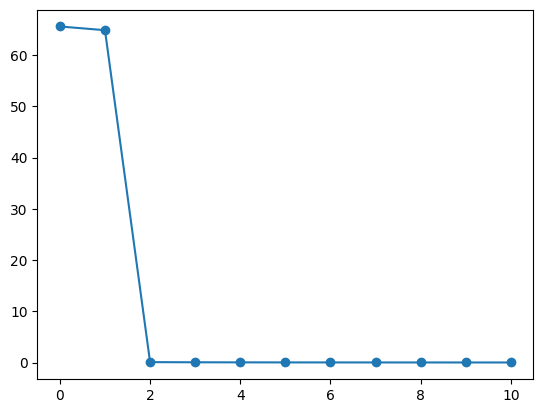

In [ ]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    epochs = 100
    eta = 2.0 * np.ones(epochs)
    params = k, epochs, eta
    A, B, l = lorma_learn(M, O, params)
    plt.plot(l , '-o')
    return M, A, B

M, A, B = check_lorma_learn()

### Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization. 

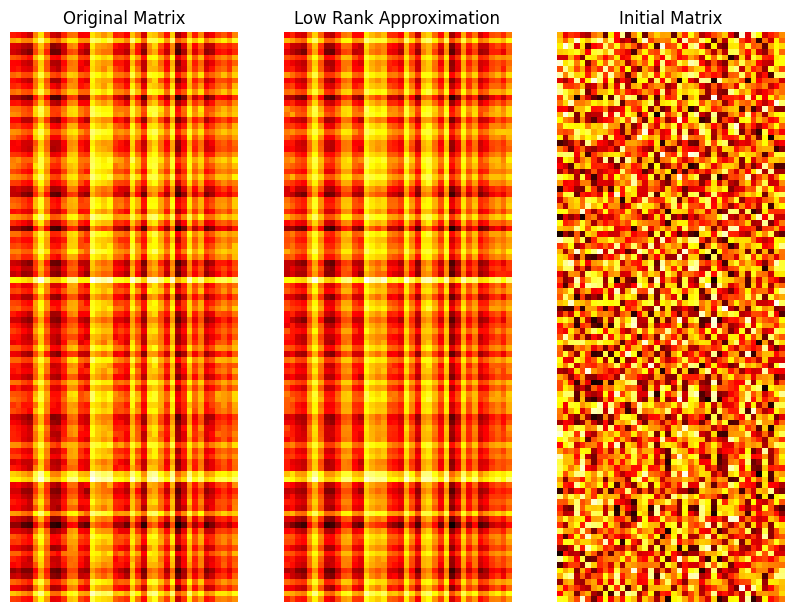

In [ ]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(A, B), 'Low Rank Approximation', 2)
show_mat(lorma(Ar, Br), 'Initial Matrix', 3)

<hr style="border:3px solid blue"> </hr>

## **Part 2: Movie Recommendation**

In movie recommendation, you are given data about users and their movie preferences, and you're tasked with recommending movies that the users have not seen and would like. In lecture, you learned about the [Netflix Prize](https://www.netflixprize.com), which awarded 1 million dollars to a team that  significantly improved their in-house movie recommendation system.

An interesting tidbit: The team that finished second in 2008 was comprised of three Princeton undergraduates! [[article]](https://www.cs.princeton.edu/news/article/princeton-undergraduates-challenge-1000000-netflix-prize)

### MovieLens dataset and Pandas library    
We will be using a smaller dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and will be using the [pandas](https://pandas.pydata.org/) library (specifically [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) to work with the dataset.

Because this is the first time we're using `pandas` in the course, we'll be breaking down the steps in more detail than usual and including a few conceptual questions along the way.

For answers to questions, **answer concisely** (complete sentences are not necessary).


## Act 7: Prepare the dataset.
To prepare the dataset to run LORMA on it, you'll be using the following pandas functions:
- [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
- [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html)
- ... 

## Act 7a: Download the MovieLens dataset

Use the [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to download the MovieLens dataset. Specifically, we'll be loading data from the `ratings.csv` file.

In [ ]:
# Imports for loading and splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Act 7a: Download the MovieLens dataset into a pandas dataframe (hint: use pd.read_csv)
movie_ratings_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/ratings.csv'
movielens_df =  pd.read_csv(movie_ratings_path)
movielens_df # show dataframe as output

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## Act 7b: `pd.read_csv` Questions

**Q1: How many rows and columns are in the dataframe?**

**Q1 Answer:** 100836 rows, 4 columns

**Q2: What are the columns in the dataframe (state each column name and your best guess as to what it stores)?**

**Q2 Answer:** 

userId - user

movieId - a movie that the user watched

rating - the rating they gave it

timestamp - the time at which the rating was submitted

**Q3: Explain the data stored in the first row (row index 0).**

**Q3 Answer:** User 1 watched movie 1 and gave it a rating of 4 stars, timestamped at 964982703

## Act 7c: Convert DataFrame to matrix
 Convert the dataframe into a matrix where the rows (i.e. index) are users, the columns are movies, and the values are ratings.

 Use the [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) function on the dataframe (i.e. `movielens_df.pivot(...)`)

In [ ]:
matrix_df = movielens_df.pivot(index = 'userId', columns = 'movieId', values = 'rating')
matrix_df # show dataframe as output

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Act 7d: Data Preprocessing

**Why are there `NaN` values in the `matrix_df` dataframe?**

**Answer:** These are movies that the user did not watch/rate

It's important to preprocess the data to get it into the right format. Let's replace the `NaN` values with a default value of `-1`. (Hint: Use the [`pandas.DataFrame.fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) function).

Finally, let's convert the pandas DataFrame object into a 2D numpy array (i.e. a matrix). (Hint: Use the [`pandas.DataFrame.to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html) function).

Tip: You can chain the above two commands together with Python dot notation (i.e. `<python object>.<function a>.<function b>`)

In [ ]:
missing_value = -1
movielens_matrix = matrix_df.fillna(missing_value).to_numpy()
movielens_matrix # show dataframe as output

array([[ 4. , -1. ,  4. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       ...,
       [ 2.5,  2. ,  2. , ..., -1. , -1. , -1. ],
       [ 3. , -1. , -1. , ..., -1. , -1. , -1. ],
       [ 5. , -1. , -1. , ..., -1. , -1. , -1. ]])

In [ ]:
# check data processing step
def check_data_processing(M):
  assert(np.sum(M == -1) == 5830804)
  assert(M.shape[0] == 610)
  assert(M.shape[1] == 9724)
  assert(M.dtype == 'float64')
  assert(M[0][0] == 4)
  assert(M[0][1] == -1)
  print("Matrix passes basic data processing checks.")

check_data_processing(movielens_matrix)

Matrix passes basic data processing checks.


In the next cell, we provide the last data processing step.

We create an observed matrix called `movielens_observed` that stores a 1 where we have user ratings and a 0 otherwise.


In [ ]:
# Create the observed matrix with 1s where we have user ratings for a given movie
# and 0s otherwise
movielens_observed = np.where(matrix_df > 0, 1, 0)
movielens_observed # show dataframe as output

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Act 8: Run LORMA on the MovieLens dataset.

Implement the following in the next code block:
1. Save a normalized version of the MovieLens data using `get_normalized_matrix`.
2. Define the parameters for LORMA (use rank = 40, epochs = 2000, eta = 10.0 for all epochs)
3. Run LORMA using the `lorma_learn` function
4. Plot losses to make sure they are decreasing.

**Hint:** Look at the function definition for `check_lorma_learn` for sample code on how to do steps 2-3.

**Note:** Running LORMA for 2000 epochs on the MovieLens dataset will take ~10 minutes in Colab.

Epoch  1 :  0.0174
Epoch  11 :  0.0173
Epoch  21 :  0.0171
Epoch  31 :  0.017
Epoch  41 :  0.0169
Epoch  51 :  0.0167
Epoch  61 :  0.0166
Epoch  71 :  0.0165
Epoch  81 :  0.0164
Epoch  91 :  0.0162
Epoch  101 :  0.0161
Epoch  111 :  0.0159
Epoch  121 :  0.0158
Epoch  131 :  0.0156
Epoch  141 :  0.0154
Epoch  151 :  0.0152
Epoch  161 :  0.015
Epoch  171 :  0.0147
Epoch  181 :  0.0145
Epoch  191 :  0.0142
Epoch  201 :  0.0139
Epoch  211 :  0.0136
Epoch  221 :  0.0133
Epoch  231 :  0.0129
Epoch  241 :  0.0126
Epoch  251 :  0.0123
Epoch  261 :  0.012
Epoch  271 :  0.0117
Epoch  281 :  0.0114
Epoch  291 :  0.0111
Epoch  301 :  0.0108
Epoch  311 :  0.0105
Epoch  321 :  0.0102
Epoch  331 :  0.01
Epoch  341 :  0.0097
Epoch  351 :  0.0095
Epoch  361 :  0.0093
Epoch  371 :  0.009
Epoch  381 :  0.0088
Epoch  391 :  0.0086
Epoch  401 :  0.0084
Epoch  411 :  0.0082
Epoch  421 :  0.0081
Epoch  431 :  0.0079
Epoch  441 :  0.0077
Epoch  451 :  0.0075
Epoch  461 :  0.0074
Epoch  471 :  0.0072
Epoch  48

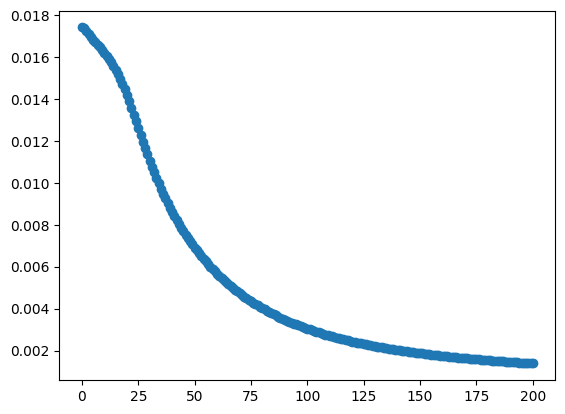

In [ ]:
"""
Act 8: Run LORMA on the MovieLens dataset.
"""
rand_seed = 10
np.random.seed(rand_seed)

# 1. Normalize the copied matrix
movielens_normalized = get_normalized_matrix(movielens_matrix, movielens_observed)

# 2. Define the parameters for LORMA
rank = 40
epochs = 2000
eta = 10.0 * np.ones(epochs)
params = rank, epochs, eta

# 3. Run LORMA using the lorma_learn function
A, B, losses = lorma_learn(movielens_normalized, movielens_observed, params)

# 4. Plot the losses to make sure they are decreasing (given)
_ = plt.plot(losses , '-o')

## Act 9
In this final section, you'll analyze the movie preferences and predicted ratings for 3 users in our dataset (user 1, 13, and 111).

We provide most of the analysis code; you'll fill in a few statements related to accessing information from the dataset.

## Act 9a: Loading movie information dataset

In [ ]:
# Load the movie names
# The data consists of rows which are movie IDs
movie_info_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/movies.csv'
movie_info_df = pd.read_csv(movie_info_path)
movie_info_df # show dataframe as output

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Act 9b: User Analysis

In the next cell, you'll analyze the user data for 3 specific users.

For each of the 3 users, we first compute the top `p` (i.e. top 10) movies that were most highly rated by that user.

Then, in the inner for loop (`for movie in top_p`), store the movie title, user rating, and movie name in their respective variables. Finally, you'll print out that information for the top `p` movies for that user. 

Hints:
- Use the [`.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) function on `movie_info_df` to get the movie title and movie name
- Get the user rating from the unnormalized matrix (i.e. `movielens_matrix`)

In [ ]:
"""
We'll pick three users and see what movies they rated highly before, and what movies your model predicted.
Hopefully there is some correlation!

In this cell you will print out the top-p movies they rated most highly.
"""

# Pick three users to recommend movies to
users = [1, 13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10
for user in users:
    print("\nUser {} liked the following:\n".format(user))
    
    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-movielens_matrix[user])
    top_p = movie_order[:p]
    
    # Print the top p movies
    for movie in top_p:
        # Store the movie title, user rating, and movie name
        movie_title = movie_info_df.iloc[movie]['title']
        user_rating = movielens_matrix[user, movie]
        movie_name = movie_info_df.iloc[movie]['genres']
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(
            movie_title,
            user_rating,
            movie_name))


User 1 liked the following:

	The Final Girls (2015)                             rated 5.0  genres Comedy|Horror                 
	Conan the Barbarian (2011)                         rated 5.0  genres Action|Adventure|Fantasy      
	I'm Still Here (2010)                              rated 5.0  genres Comedy|Drama                  
	The Hungover Games (2014)                          rated 5.0  genres Comedy                        
	Ender's Game (2013)                                rated 5.0  genres Action|Adventure|Sci-Fi|IMAX  
	Zombie Strippers! (2008)                           rated 5.0  genres Comedy|Horror                 
	10,000 BC (2008)                                   rated 4.5  genres Adventure|Romance|Thriller    
	For Richer or Poorer (1997)                        rated 4.5  genres Comedy                        
	Piranha (Piranha 3D) (2010)                        rated 4.5  genres Action|Horror|Thriller        
	Sunshine Cleaning (2008)                           rated 4.5

## Act 9c: Recommended Movies

In the next cell, you'll print out the top `p` (i.e. top 10) movies that are predicted for the 3 users we're studying.

For each of the 3 users, we first compute the predicted ratings for that user and save the top `p` predicted movies in descending order (we set the ratings for observed movies to -infinity so that we only save the top `p` movies that haven't been rated by the user).

Then, in the inner for loop (`for movie in top_p`), store the movie title and movie genre (this should be similar to what you did in Act 9b).

In [ ]:
"""
User 1 seems to like Comedy and Horror
User 13 seems to like Drama and Romance
User 111 seems to like Sci-Fi and Adventure

Now let's make our predictions on the test data and see what movies we can recommend

"""

for user in users:
    print("\nRecommend the following movies to User {}\n".format(user))
    
    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B
    
    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[movielens_observed[user]] = -np.inf
    
    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]
    
    # Print the recommended movies
    for movie in top_p:
      movie_title = movie_info_df.iloc[movie]['title']
      movie_genre = movie_info_df.iloc[movie]['genres']
      print("\t{:<60} genres {:<30}".format(movie_title[:60], # cap length of movie title to 60 char 
                                            movie_genre))


Recommend the following movies to User 1

	Cruise, The (1998)                                           genres Documentary                   
	Rumble in the Bronx (Hont faan kui) (1995)                   genres Action|Adventure|Comedy|Crime 
	Robin Hood: Men in Tights (1993)                             genres Comedy                        
	Corporation, The (2003)                                      genres Documentary                   
	Clueless (1995)                                              genres Comedy|Romance                
	Wallace & Gromit: The Best of Aardman Animation (1996)       genres Adventure|Animation|Comedy    
	Leaving Las Vegas (1995)                                     genres Drama|Romance                 
	Fried Green Tomatoes (1991)                                  genres Comedy|Crime|Drama            
	Conan the Barbarian (2011)                                   genres Action|Adventure|Fantasy      
	Ghosts of Mississippi (1996)                            

## ACT10: Answer the following question in the cell below 

**Question:** Do you see any correlation between the top rated movies (Act 9b) and the top predicted movies (Act 9c)? 

**For each user**, answer the question and briefly explain your reasoning in **1 sentence (total 3 sentences; 1 per user).**

For each user,
- If yes, briefly explain the correlation you observe. 
- If no, briefly explain why you don't believe there's a correlation between their top rated movies and top predicted movies.

**Note:** The correlation, if there's any, may be weak.

**Answer:**

User 1: Yes there was a weak correlation as their highly rated movies were in Comedy, Action, Horror, and Drama and they were recommended Comedy and Action movies

User 13: Yes, this user enjoyed Action, Drama, War, Romance, and Action and was recommended Action, Drama, Romance, and documentaries about war related topics

User 111: Yes, they highly rated moved in Adventure, Sci-Fi, Mystery, Thriller, and Romance which correlates with the recommended movies which were in Drama, Sci-Fi, Thruller, and Adventure 


